## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-spaceNet-wavelet-green' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\wavelet\\approx1e5\\green'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta

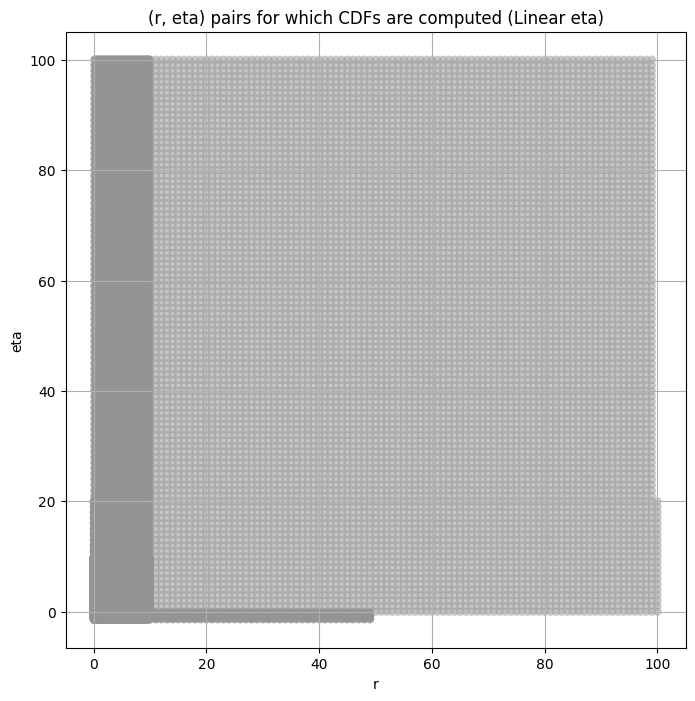

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:59<00:00, 1669.21it/s]


Layer 3


100%|██████████| 100000/100000 [01:00<00:00, 1666.18it/s]


Layer 4


100%|██████████| 100000/100000 [01:02<00:00, 1599.91it/s]


Layer 5


100%|██████████| 100000/100000 [01:12<00:00, 1387.32it/s]


Layer 6


100%|██████████| 100000/100000 [01:27<00:00, 1138.83it/s]


Layer 7


100%|██████████| 100000/100000 [01:32<00:00, 1083.28it/s]


Layer 8


100%|██████████| 100000/100000 [01:21<00:00, 1228.34it/s]


Layer 9


100%|██████████| 100000/100000 [01:22<00:00, 1206.60it/s]


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  
layer                             
2        6.877853        27208.0  
3       25.538519       108832.0  
4       18.198275       333298.0  
5       26.454138      1149538.0  
6       22.231544      4251250.0  
7       60.509160     17005000.0  
8      216.776810     68020000.0  
9      464.557600    272080000.0

## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


  0%|          | 69/55966 [00:00<02:42, 343.52it/s]

100%|██████████| 55966/55966 [02:59<00:00, 311.17it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 27208, Without approximation : 27208.0


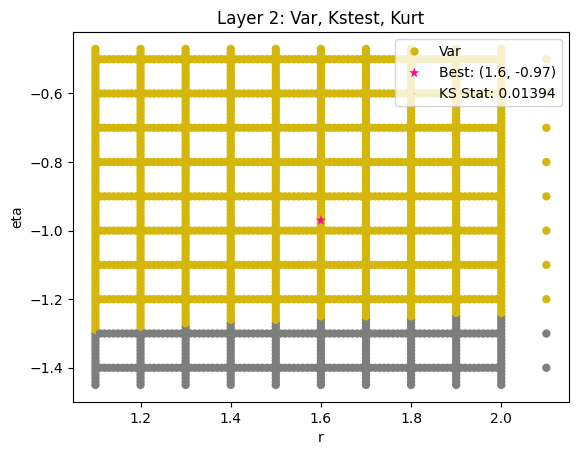

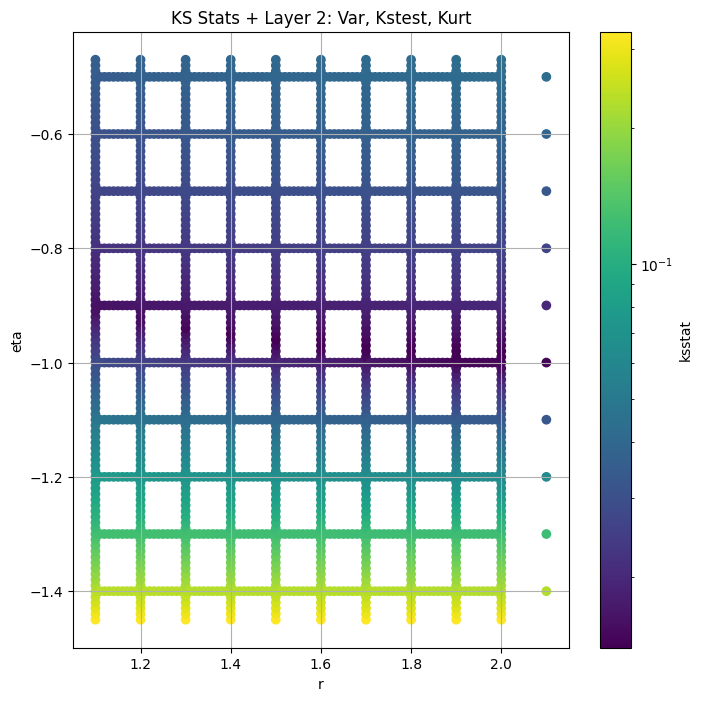

####
Layer  3


100%|██████████| 55966/55966 [11:11<00:00, 83.39it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 108832.0


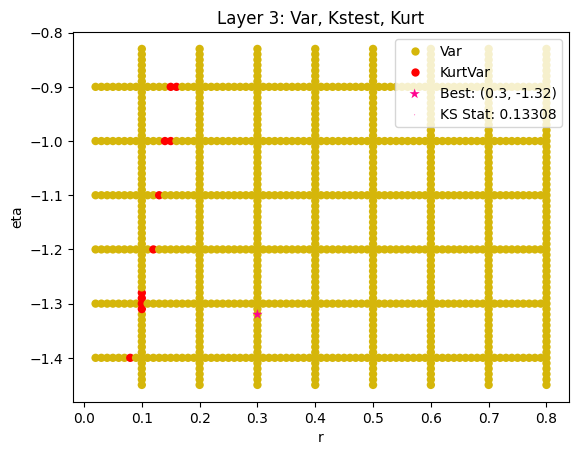

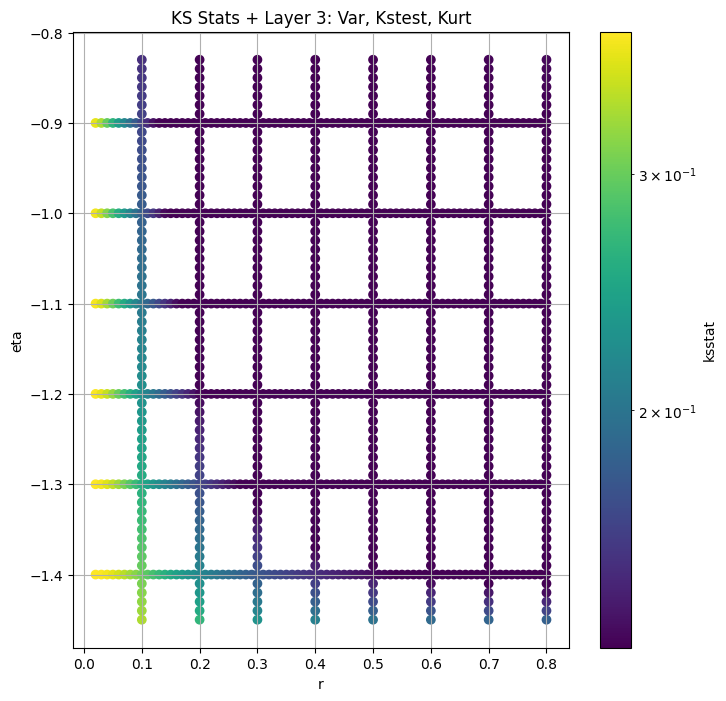

####
Layer  4


100%|██████████| 55966/55966 [11:48<00:00, 79.01it/s]  


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 333298.0


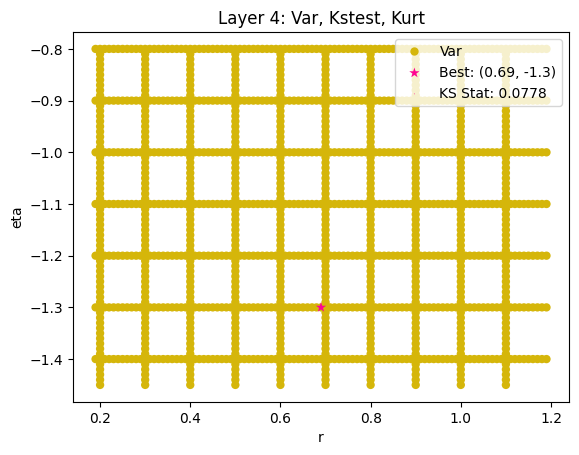

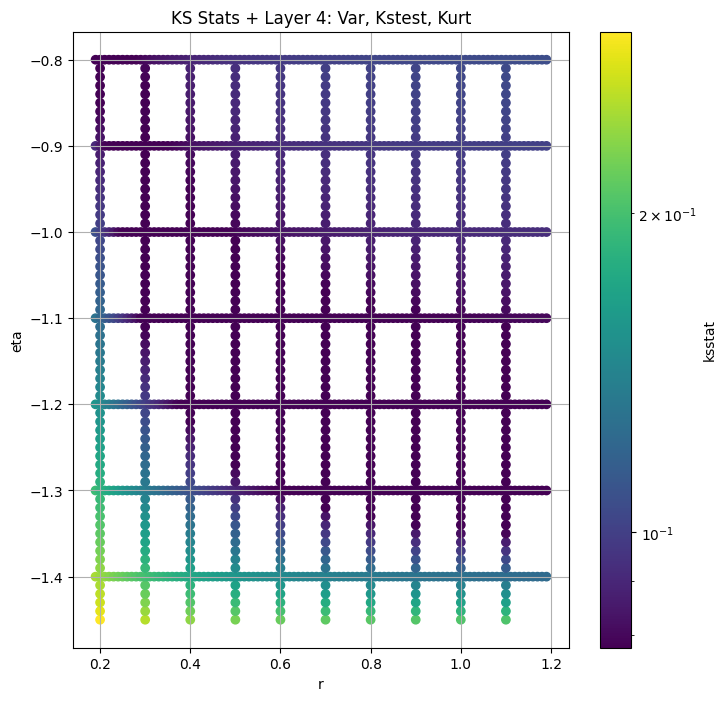

####
Layer  5


100%|██████████| 55966/55966 [11:02<00:00, 84.43it/s]  


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1149538.0


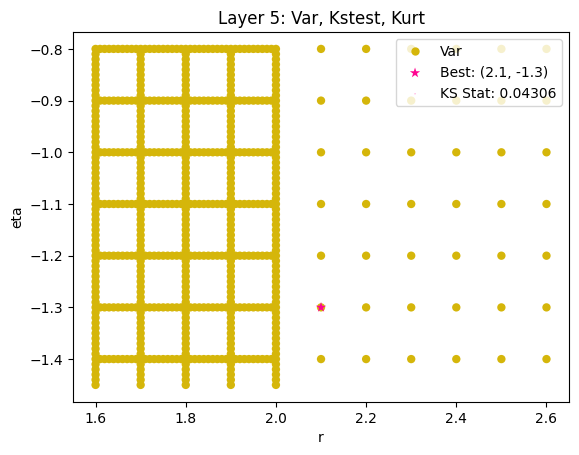

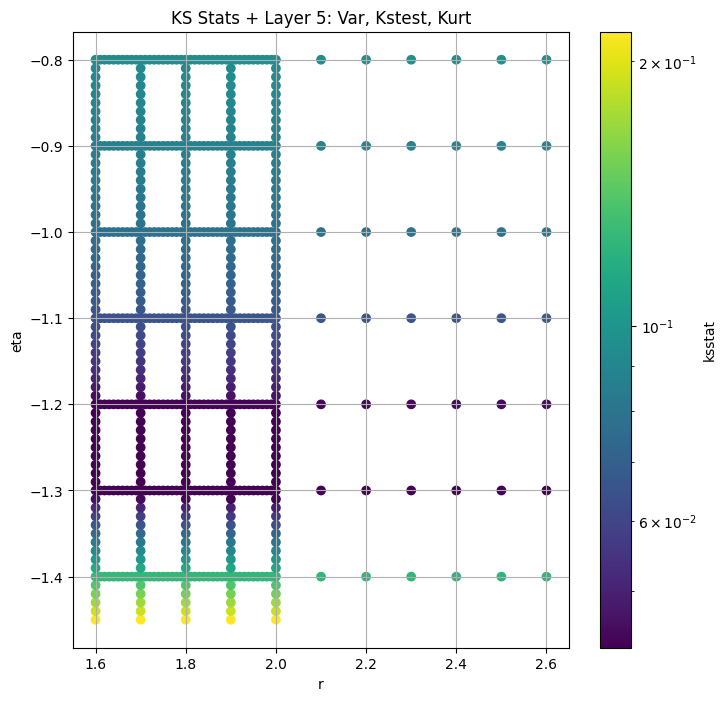

####
Layer  6


100%|██████████| 55966/55966 [09:54<00:00, 94.18it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 4251250.0


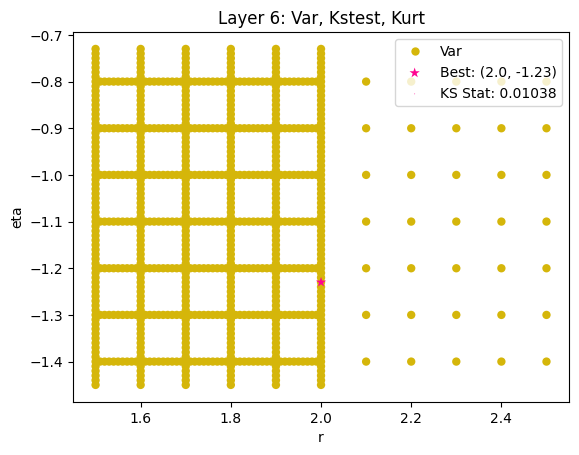

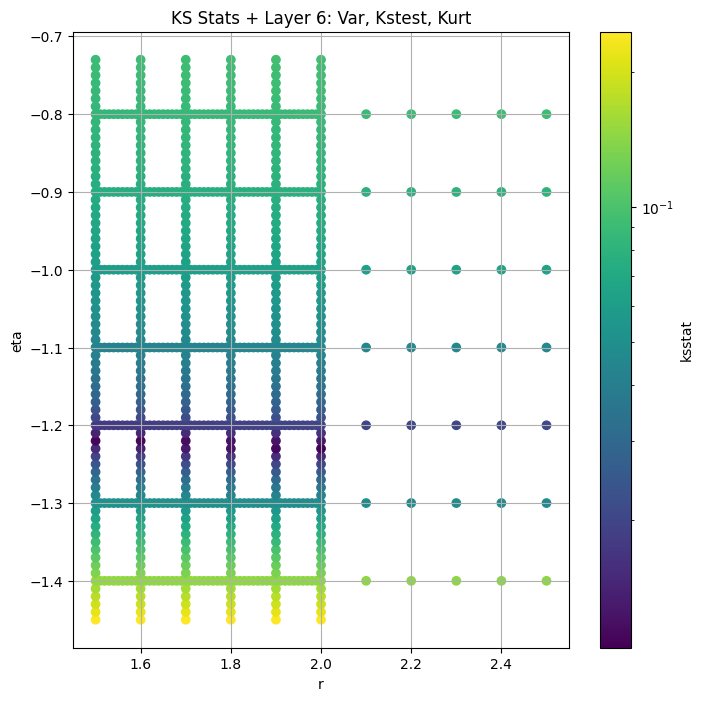

####
Layer  7


100%|██████████| 55966/55966 [09:53<00:00, 94.35it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 17005000.0


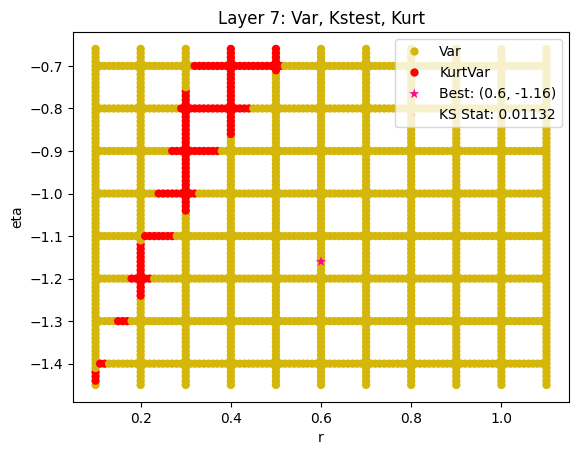

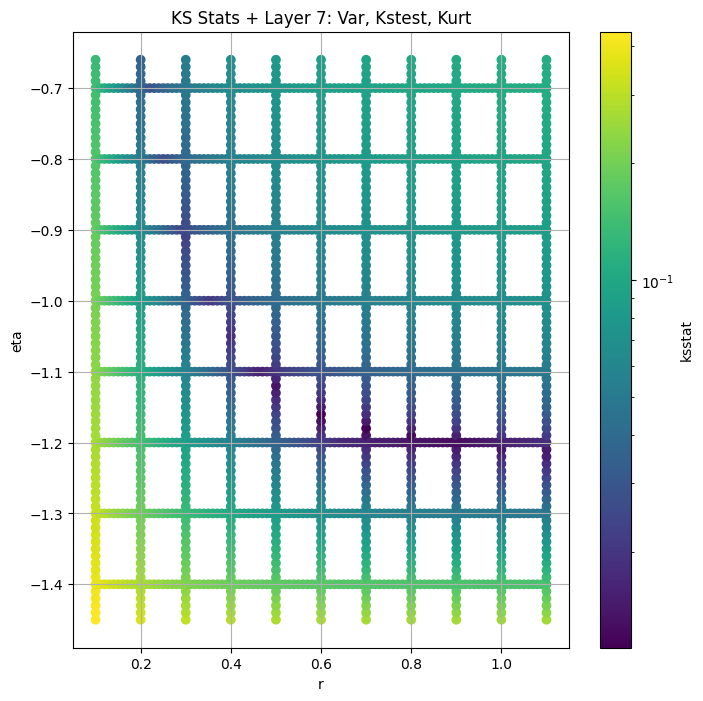

####
Layer  8


100%|██████████| 55966/55966 [09:36<00:00, 97.02it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 68020000.0


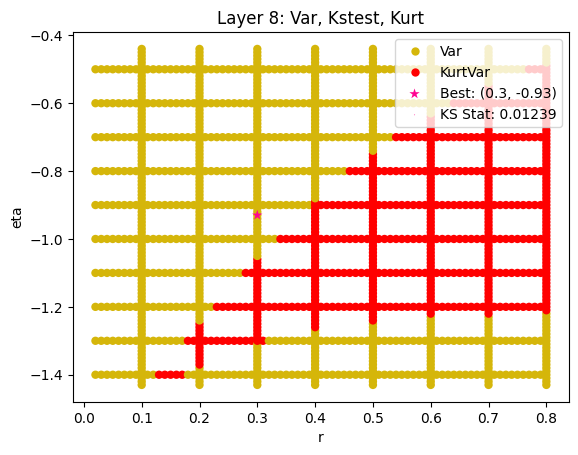

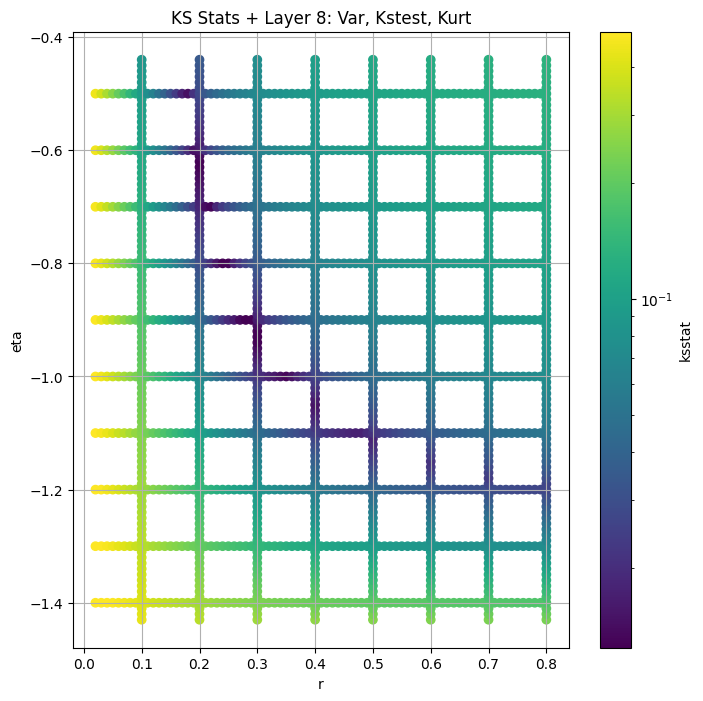

####
Layer  9


100%|██████████| 55966/55966 [10:29<00:00, 88.86it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 272080000.0


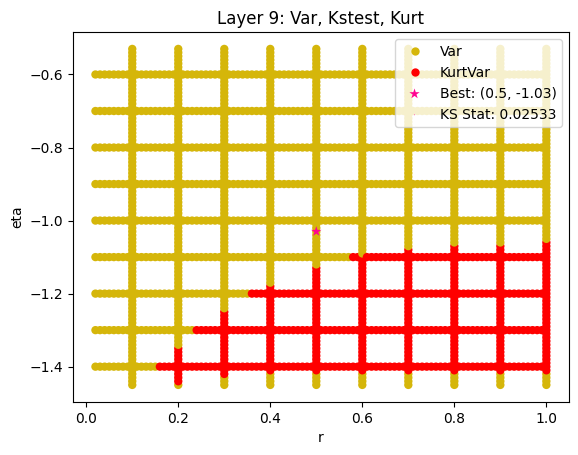

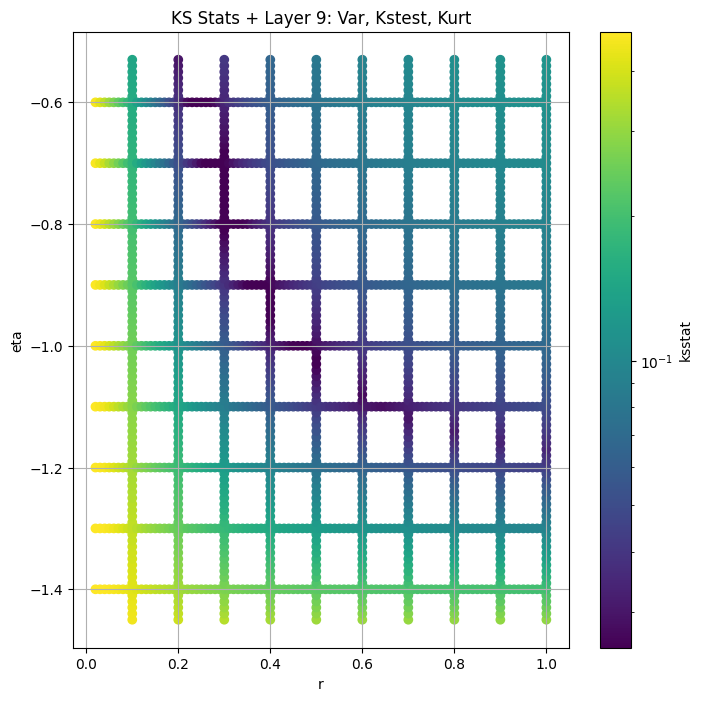

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        6.877853        27208.0       1.60        -0.97   54039.904937   
3       25.538519       108832.0       0.30        -1.32    1506.594695   
4       18.198275       333298.0       0.69        -1.30    6103.234328   
5       26.454138      1149538.0       2.10        -1.30    3330.115714   
6       22.231544      4251250.0       2.00        -1.23     606.675369   
7       60.509160     17005000.0       0.60        -1.16      37.057163   
8      216.776810     68020000.0       0.30        -0.93       0.156030   
9      464.557600    272080000.0       0.50        -1.03       0.560322   

       kstest_stat_initial  kstest_stat_cutoff_0.05  
layer                                                
2                 0.013942                 0.008227  
3                 0.133080                 0.004115  
4                 0.077800                 0.002352  
5                 0.043063                 0.001267  
6                 0.010375                 0.000659  
7                 0.011315                 0.000329  
8                 0.012393                 0.000165  
9                 0.025333                 0.000082

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:01<00:00, 251.56it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:04<00:00, 82.47it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 95.12it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 96.11it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 93.98it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 95.02it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 93.06it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 92.32it/s] 


Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
layer                                                                     
2        6.877853        27208.0       1.60        -0.97   54039.904937   
3       25.538519       108832.0       0.30        -1.32    1506.594695   
4       18.198275       333298.0       0.69        -1.30    6103.234328   
5       26.454138      1149538.0       2.10        -1.30    3330.115714   
6       22.231544      4251250.0       2.00        -1.23     606.675369   
7       60.509160     17005000.0       0.60        -1.16      37.057163   
8      216.776810     68020000.0       0.30        -0.93       0.156030   
9      464.557600    272080000.0       0.50        -1.03       0.560322   

       kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
layer                                                              
2                 0.013942                 0.008227         6.00   
3                 0.133080                 0.004115         6.00   
4                 0.077800                 0.002352         5.90   
5                 0.043063                 0.001267         5.90   
6                 0.010375                 0.000659         5.80   
7                 0.011315                 0.000329         5.80   
8                 0.012393                 0.000165         5.80   
9                 0.025333                 0.000082         0.03   

       best_scale_eta0  kstest_stat_eta0  
layer                                     
2         1.741273e+00          0.145928  
3         1.741273e+00          0.268104  
4         1.740117e+00          0.328918  
5         1.740117e+00          0.384076  
6         1.738869e+00          0.429566  
7         1.738869e+00          0.459438  
8         1.738869e+00          0.476820  
9         3.001473e-61          0.478200

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2


(1.52, -0.973), 50 of 441
(1.54, -0.965), 100 of 441
(1.57, -0.978), 150 of 441
(1.59, -0.97), 200 of 441
(1.61, -0.962), 250 of 441
(1.64, -0.975), 300 of 441
(1.66, -0.967), 350 of 441
(1.69, -0.98), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 367.79it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 2 best parameters: ((1.52, -0.964), 0.013859991516777304)


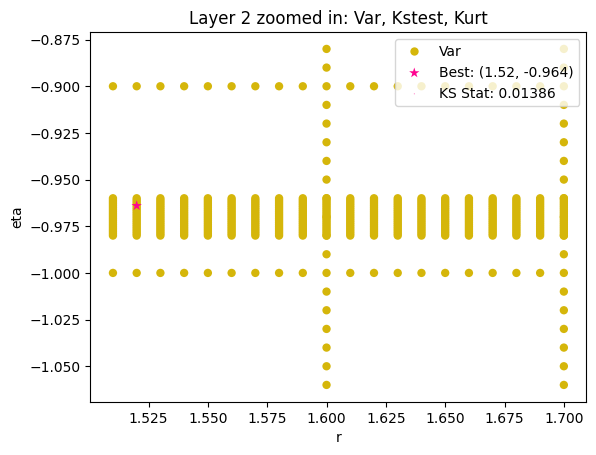

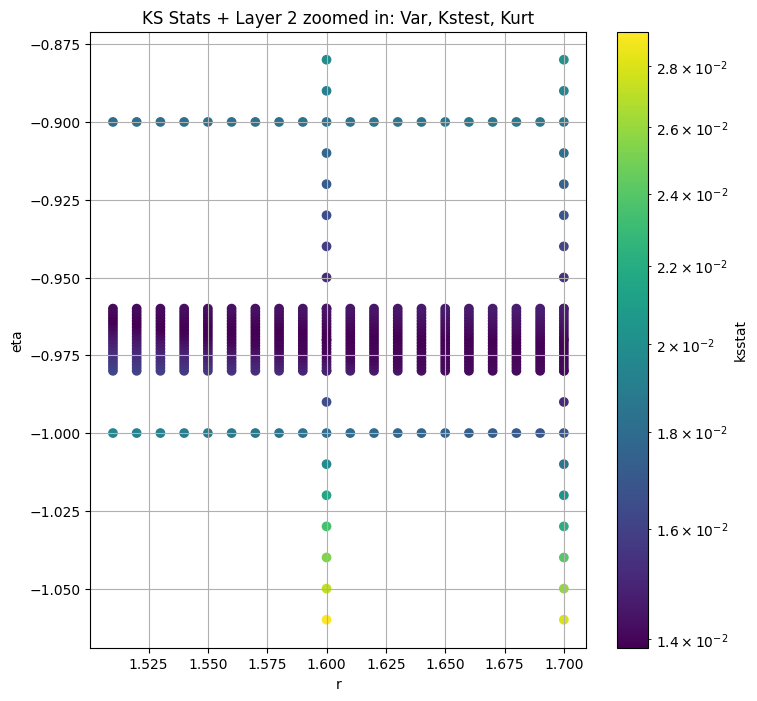

Layer 3
(0.22, -1.323), 50 of 441
(0.24, -1.315), 100 of 441
(0.27, -1.328), 150 of 441
(0.29, -1.32), 200 of 441
(0.31, -1.312), 250 of 441
(0.34, -1.325), 300 of 441
(0.36, -1.317), 350 of 441
(0.39, -1.33), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 99.63it/s] 


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((0.37, -1.321), 0.1330799999999998)


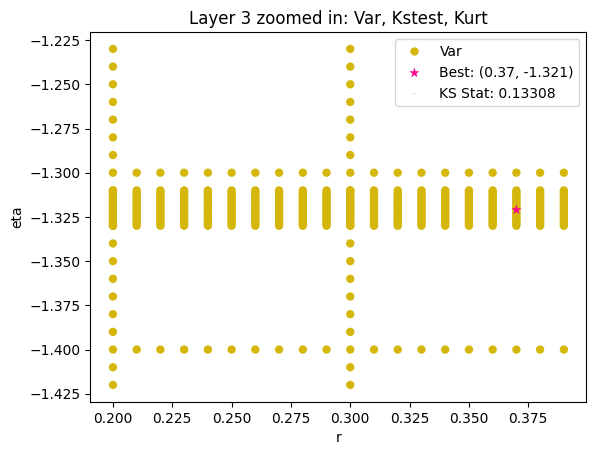

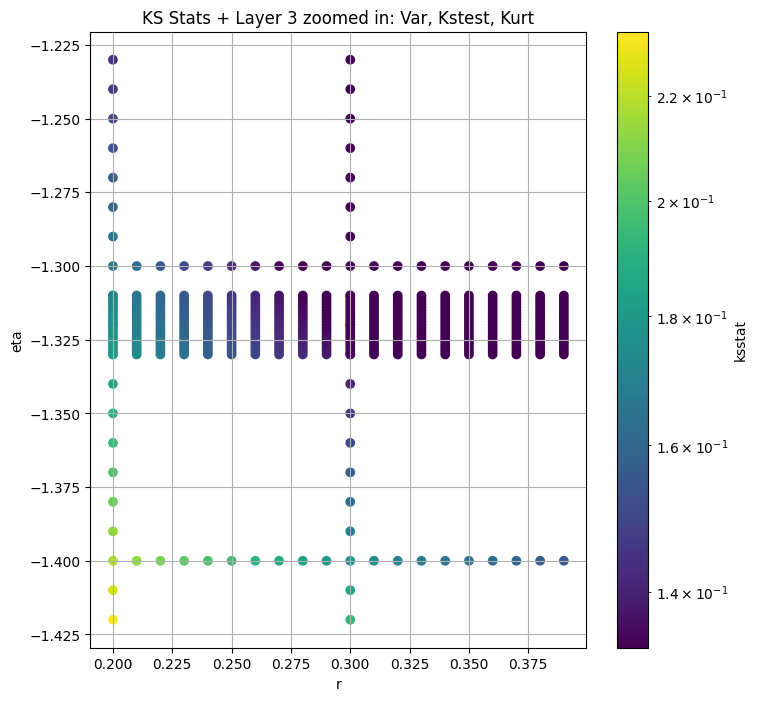

Layer 4
(0.682, -1.33), 50 of 441
(0.684, -1.25), 100 of 441
(0.687, -1.38), 150 of 441
(0.689, -1.3), 200 of 441
(0.691, -1.22), 250 of 441
(0.694, -1.35), 300 of 441
(0.696, -1.27), 350 of 441
(0.699, -1.4), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 96.17it/s] 


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.681, -1.28), 0.07779999999999987)


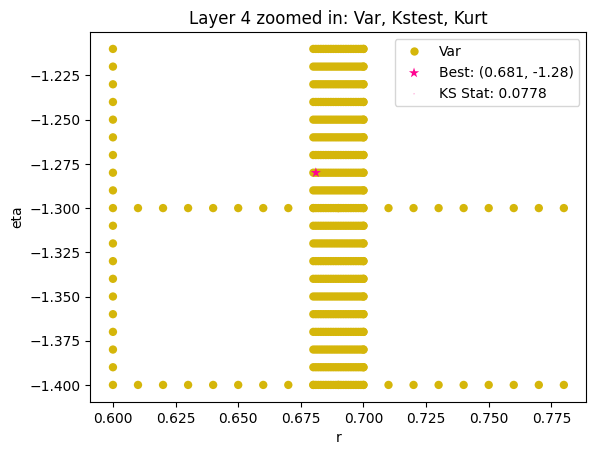

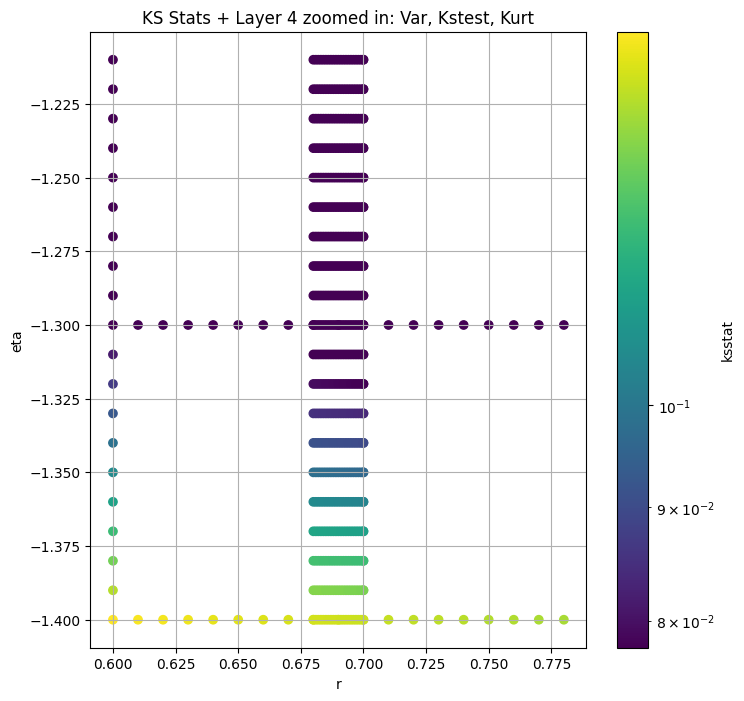

Layer 5
(2.02, -1.33), 50 of 441
(2.04, -1.25), 100 of 441
(2.07, -1.38), 150 of 441
(2.09, -1.3), 200 of 441
(2.11, -1.22), 250 of 441
(2.14, -1.35), 300 of 441
(2.16, -1.27), 350 of 441
(2.19, -1.4), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 105.52it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((2.0, -1.31), 0.043050586513633915)


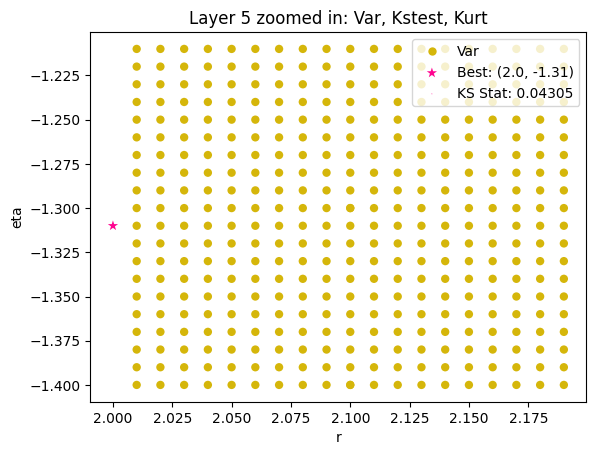

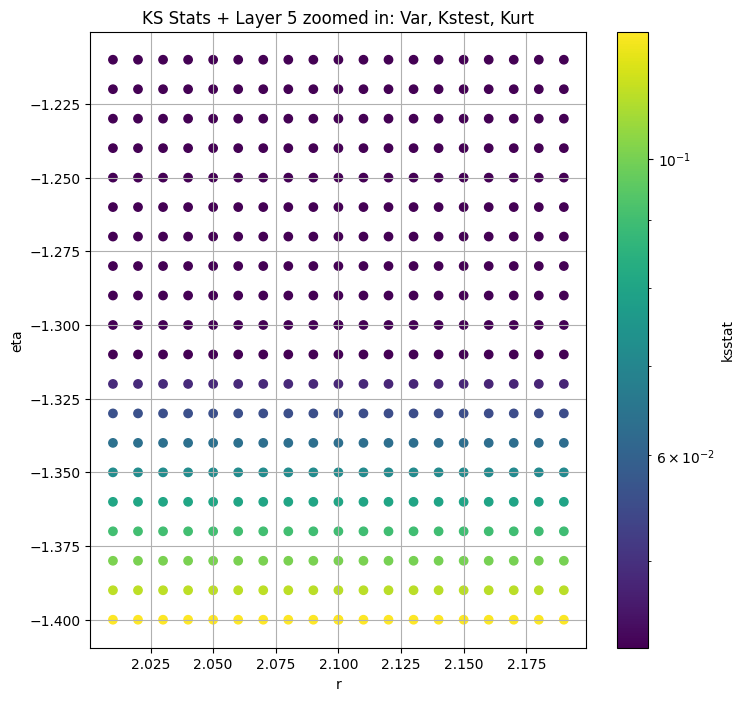

Layer 6
(1.2, -1.233), 50 of 420
(1.4, -1.225), 100 of 420
(1.7, -1.238), 150 of 420
(1.9, -1.23), 200 of 420
(2.1, -1.222), 250 of 420
(2.4, -1.235), 300 of 420
(2.6, -1.227), 350 of 420
(2.9, -1.24), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 88.83it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 6 best parameters: ((2.2, -1.23), 0.009334016508389387)


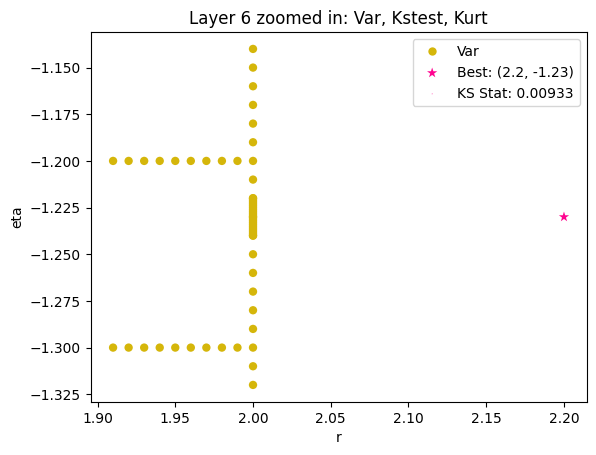

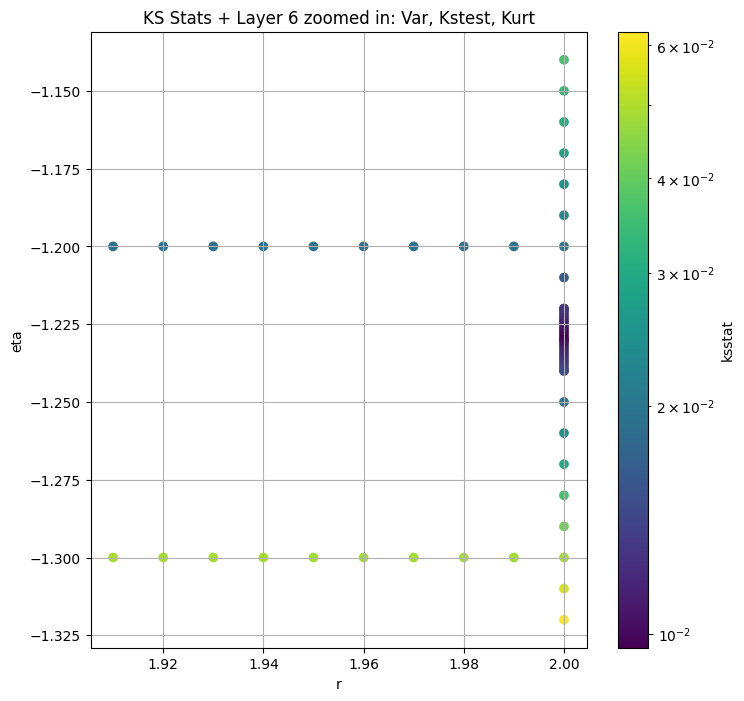

Layer 7
(0.52, -1.163), 50 of 420
(0.54, -1.155), 100 of 420
(0.57, -1.168), 150 of 420
(0.59, -1.16), 200 of 420
(0.61, -1.152), 250 of 420
(0.64, -1.165), 300 of 420
(0.66, -1.157), 350 of 420
(0.69, -1.17), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 92.64it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 layer 7 best parameters: ((0.6, -1.162), 0.010708899442185726)


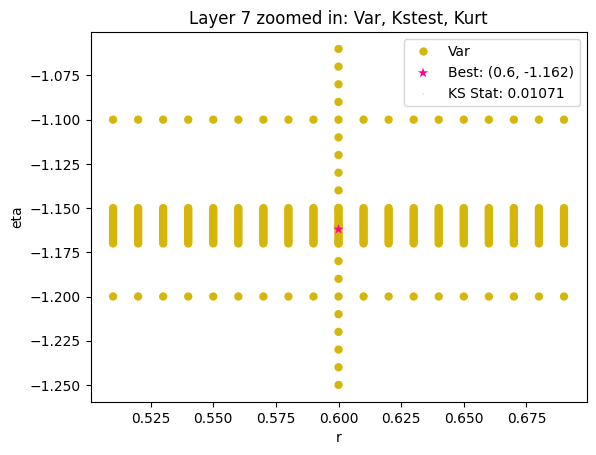

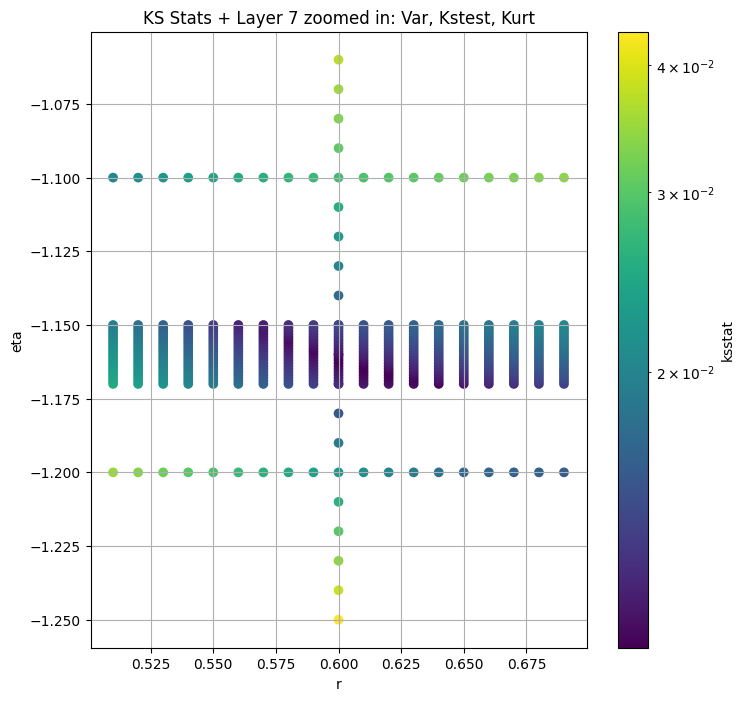

Layer 8
(0.22, -0.933), 50 of 441
(0.24, -0.925), 100 of 441
(0.27, -0.938), 150 of 441
(0.29, -0.93), 200 of 441
(0.31, -0.922), 250 of 441
(0.34, -0.935), 300 of 441
(0.36, -0.927), 350 of 441
(0.39, -0.94), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 109.03it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 8 best parameters: ((0.3, -0.937), 0.012391991921396728)


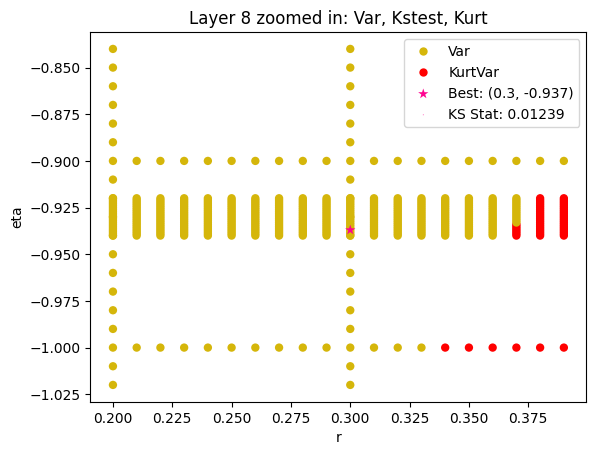

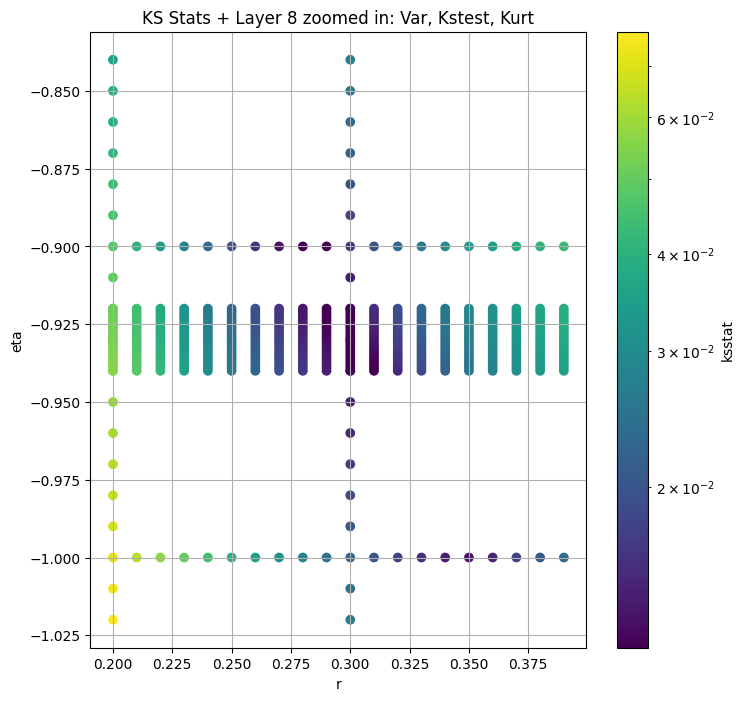

Layer 9
(0.42, -1.033), 50 of 420
(0.44, -1.025), 100 of 420
(0.47, -1.038), 150 of 420
(0.49, -1.03), 200 of 420
(0.51, -1.022), 250 of 420
(0.54, -1.035), 300 of 420
(0.56, -1.027), 350 of 420
(0.59, -1.04), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 122.70it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 9 best parameters: ((0.52, -1.04), 0.025331641257328452)


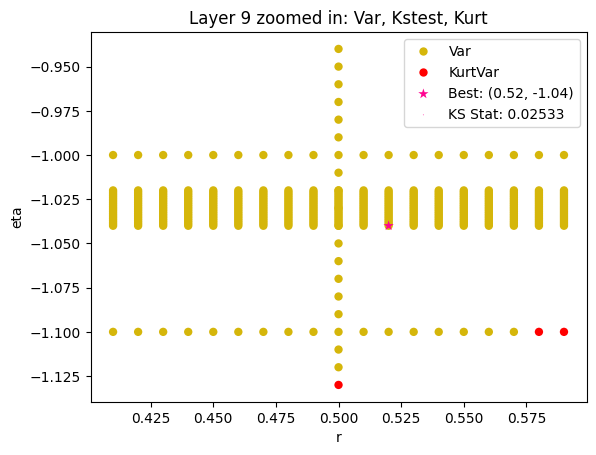

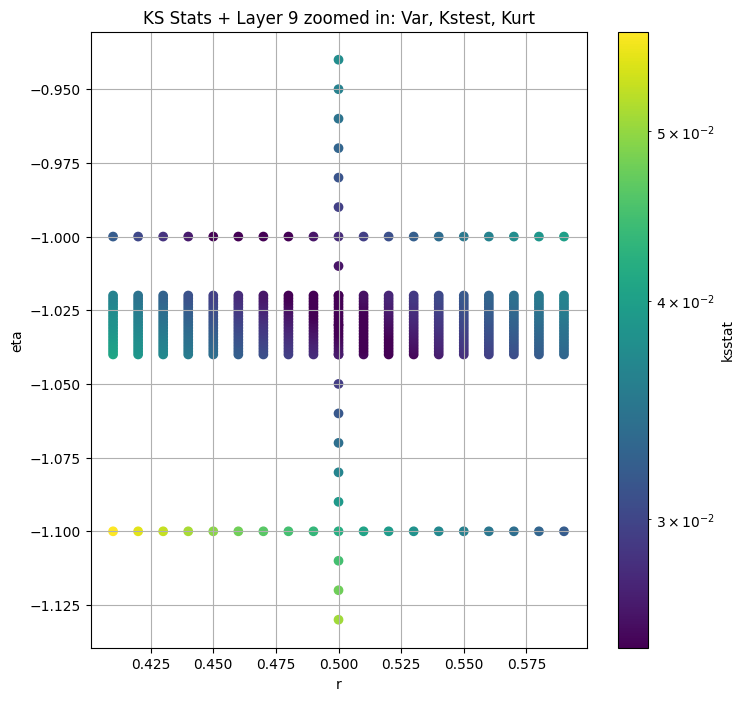

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.877853        27208.0       1.60        -0.97   54039.904937  ...   
3       25.538519       108832.0       0.30        -1.32    1506.594695  ...   
4       18.198275       333298.0       0.69        -1.30    6103.234328  ...   
5       26.454138      1149538.0       2.10        -1.30    3330.115714  ...   
6       22.231544      4251250.0       2.00        -1.23     606.675369  ...   
7       60.509160     17005000.0       0.60        -1.16      37.057163  ...   
8      216.776810     68020000.0       0.30        -0.93       0.156030  ...   
9      464.557600    272080000.0       0.50        -1.03       0.560322  ...   

       best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
layer                                                                      
2         1.741273e+00          0.145928   1.520    -0.964  52320.947677   
3         1.741273e+00          0.268104   0.370    -1.321   4276.766807   
4         1.740117e+00          0.328918   0.681    -1.280   5373.295169   
5         1.740117e+00          0.384076   2.000    -1.310   3467.403161   
6         1.738869e+00          0.429566   2.200    -1.230    614.169094   
7         1.738869e+00          0.459438   0.600    -1.162     37.334473   
8         1.738869e+00          0.476820   0.300    -0.937      0.160482   
9         3.001473e-61          0.478200   0.520    -1.040      0.654821   

       kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
layer                                                                        
2              0.013860    1.520     -0.964           0.013860         9682  
3              0.133080    0.370     -1.321           0.133080          106  
4              0.077800    0.681     -1.280           0.077800          306  
5              0.043051    2.000     -1.310           0.043051          945  
6              0.009334    2.200     -1.230           0.009334        21015  
7              0.010709    0.600     -1.162           0.010709        16606  
8              0.012392    0.300     -0.937           0.012392        12454  
9              0.025332    0.520     -1.040           0.025332         2952  

[8 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

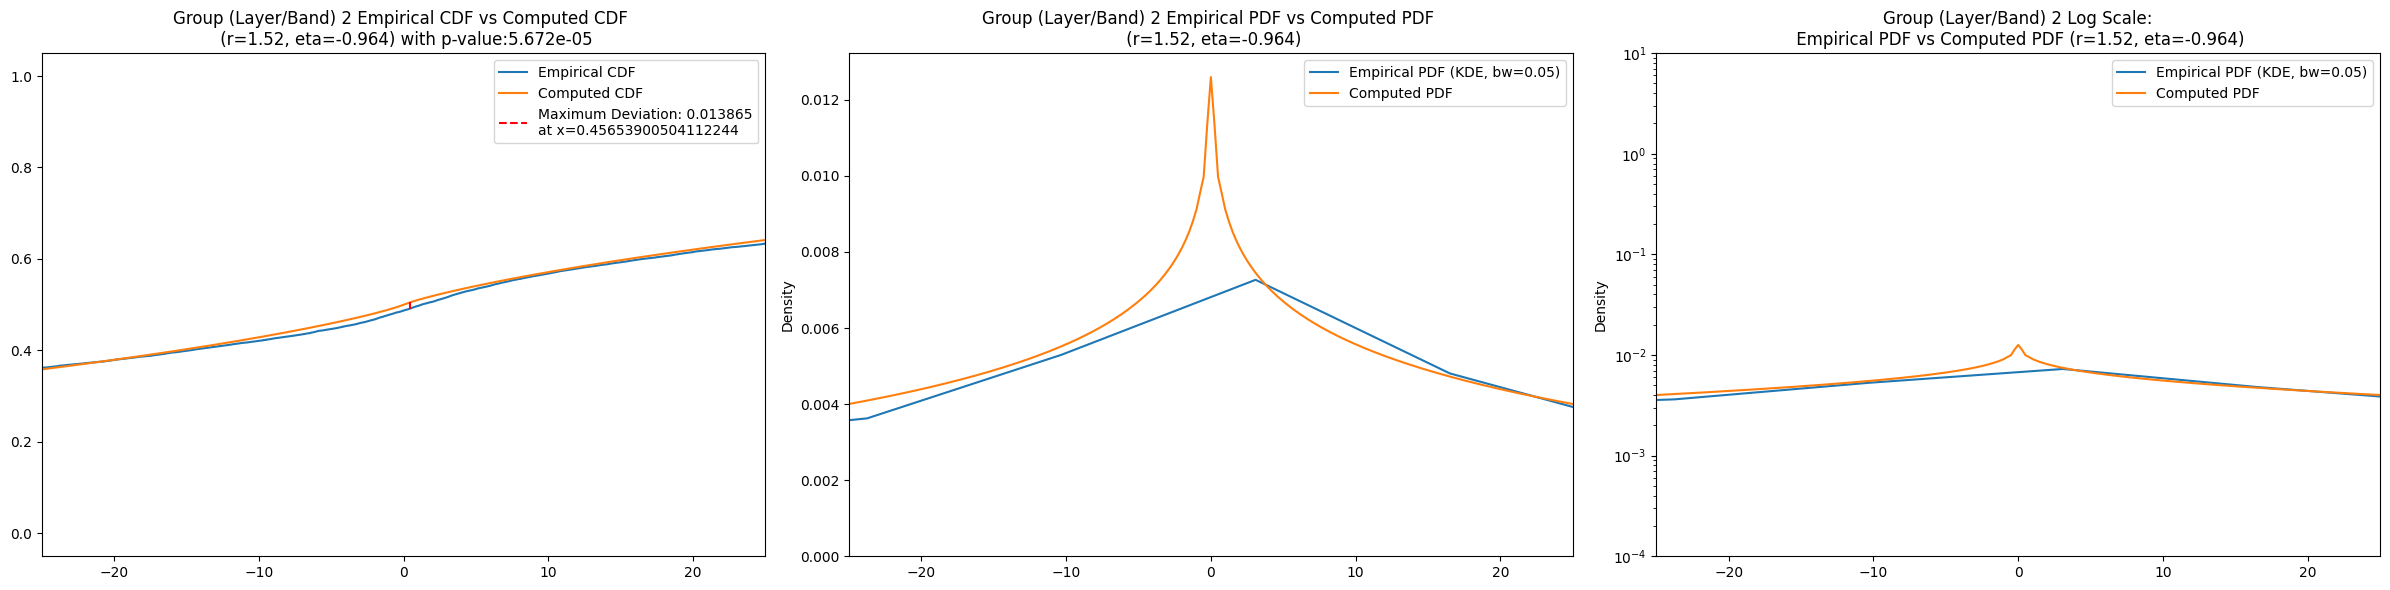

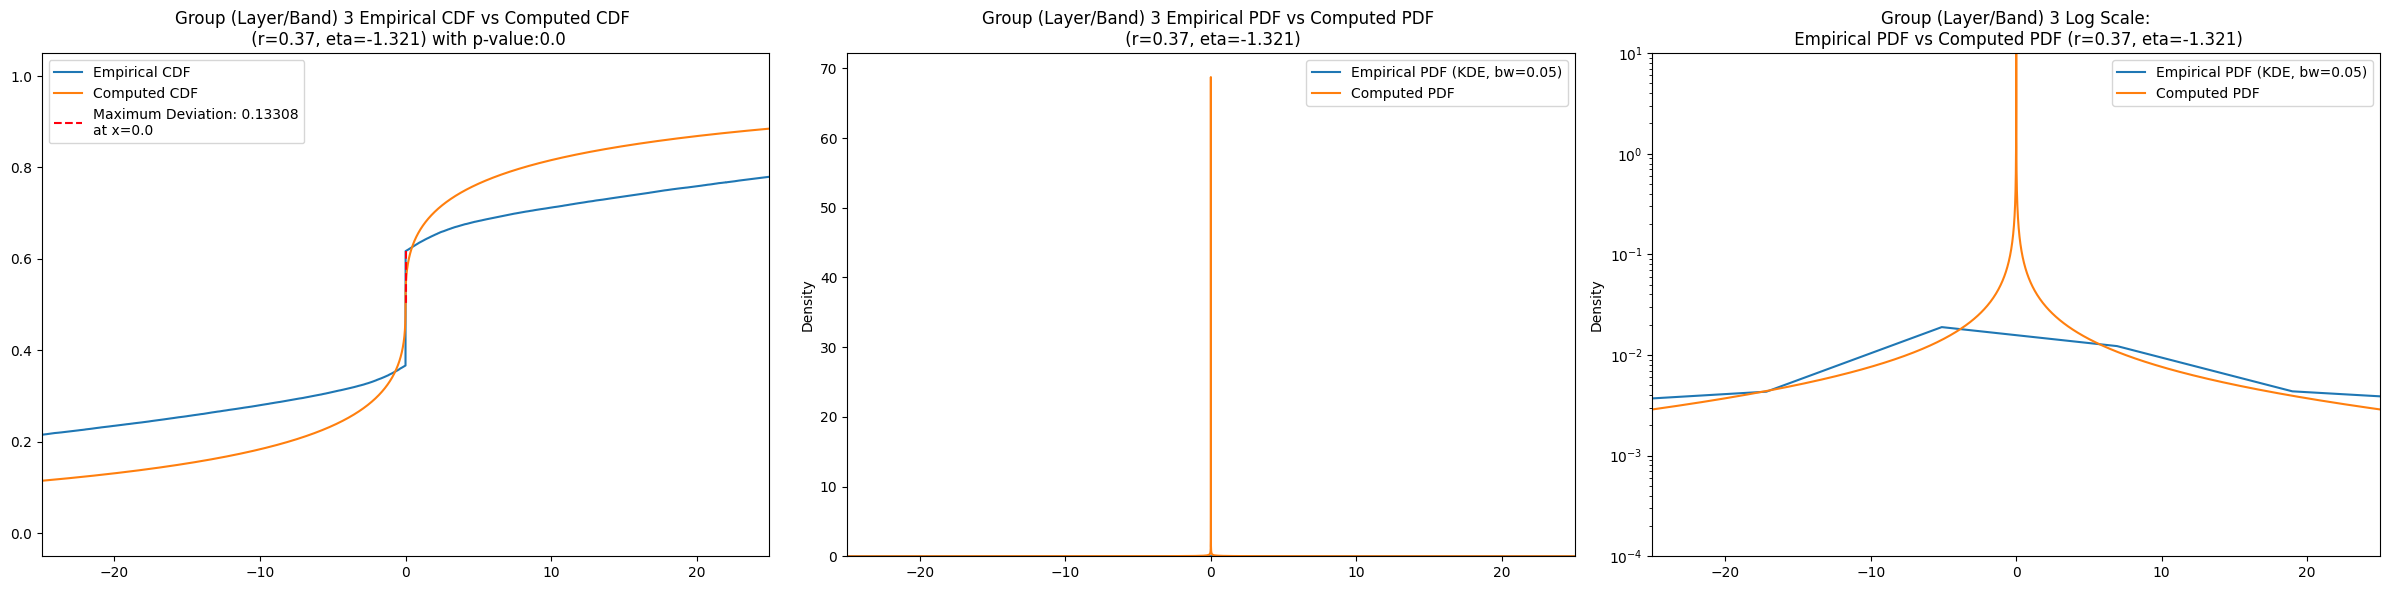

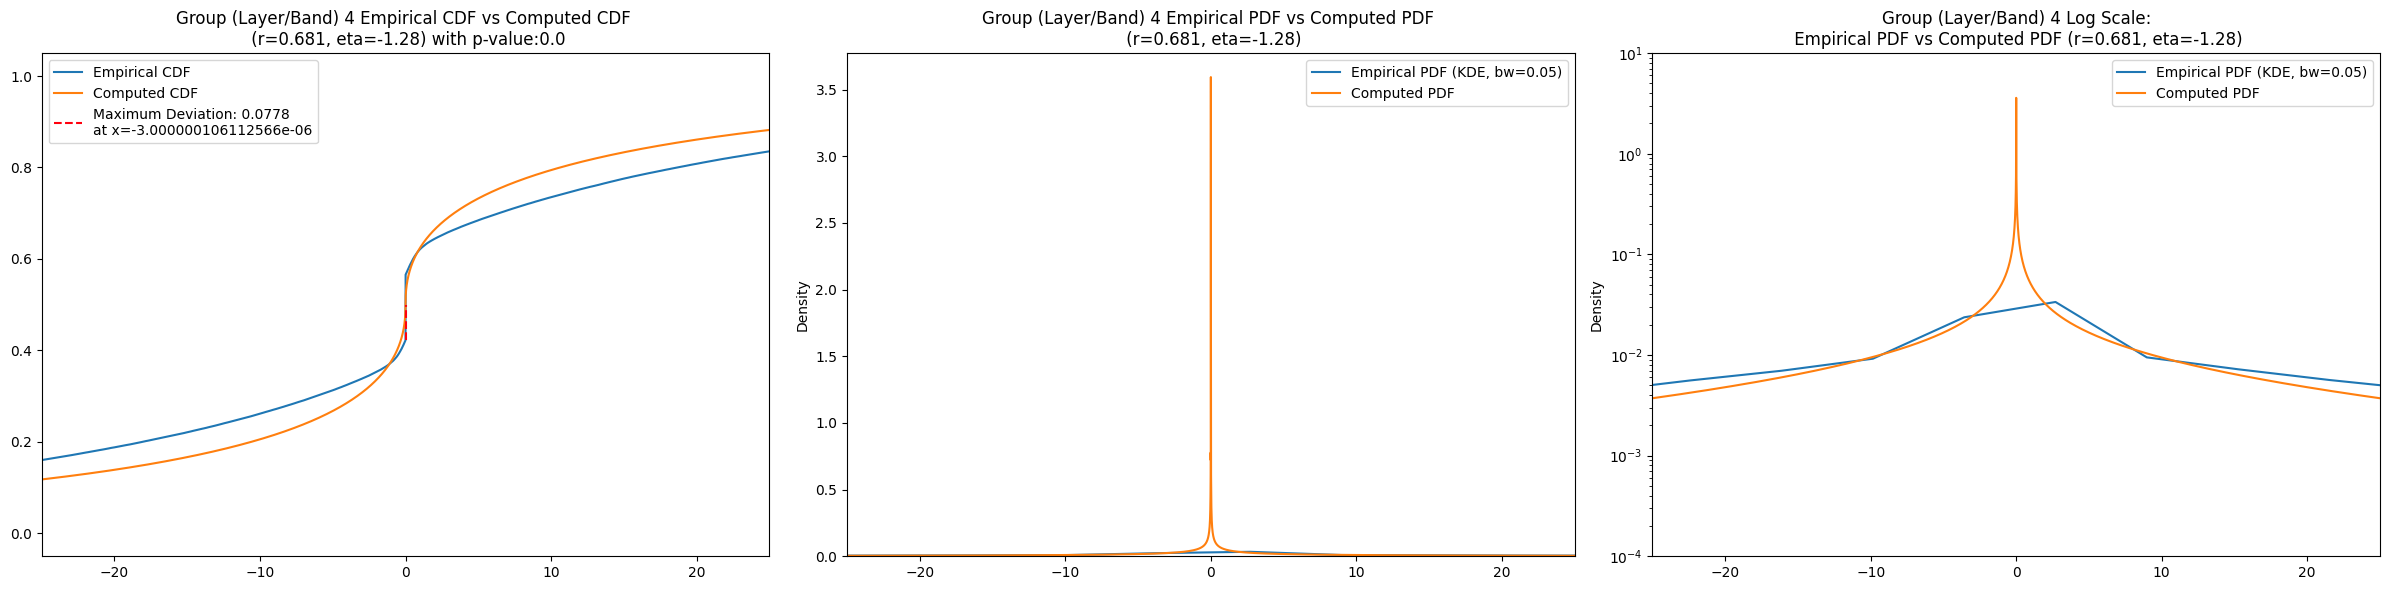

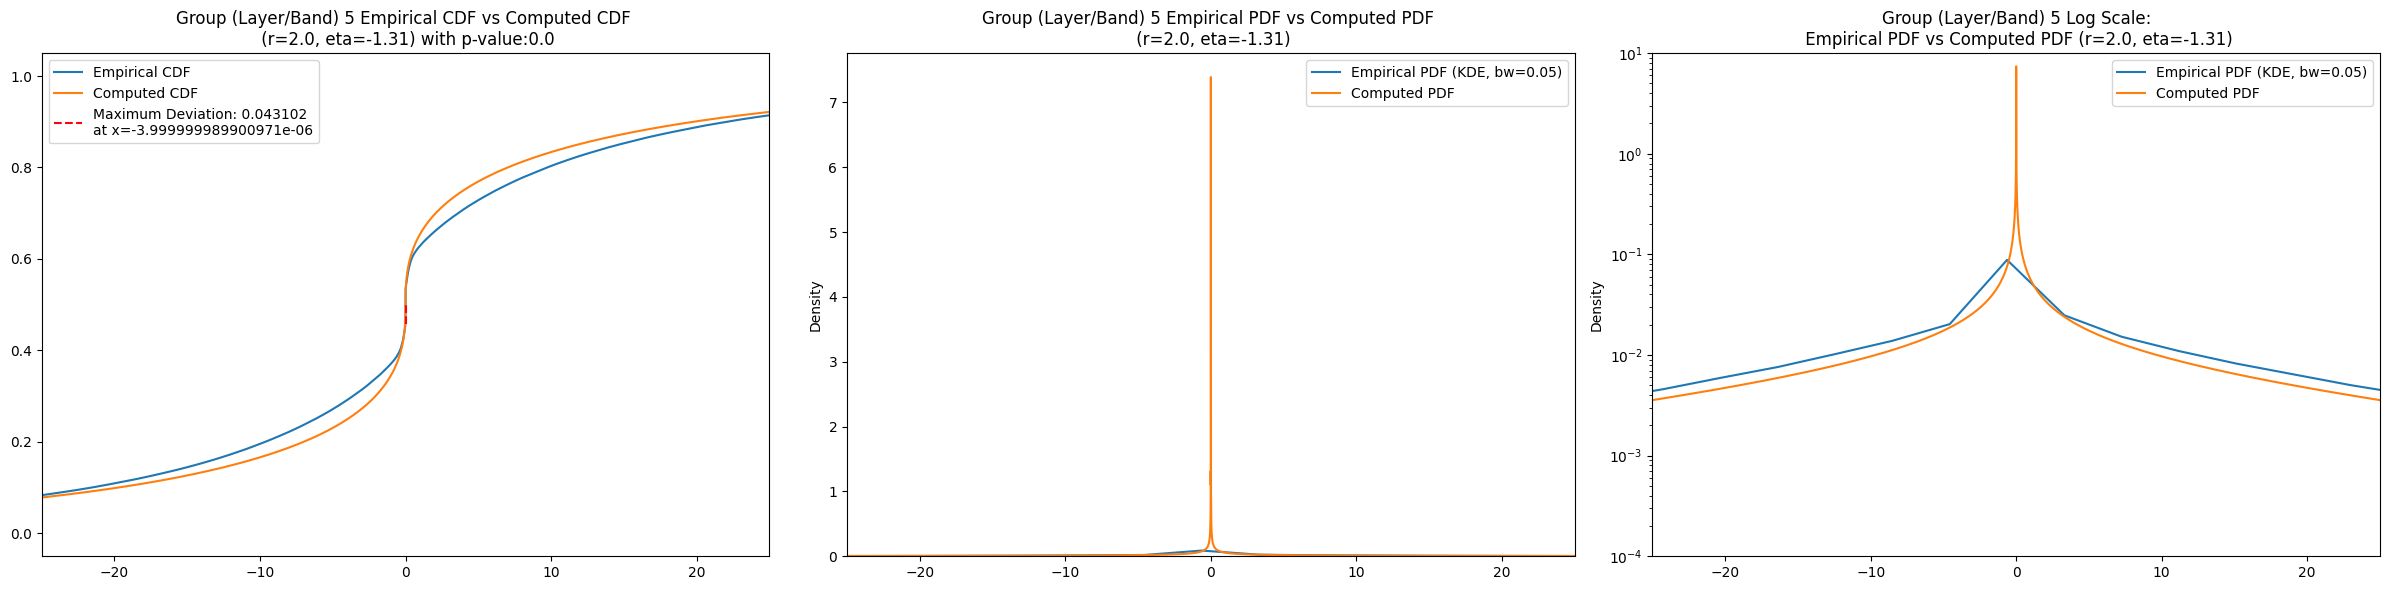

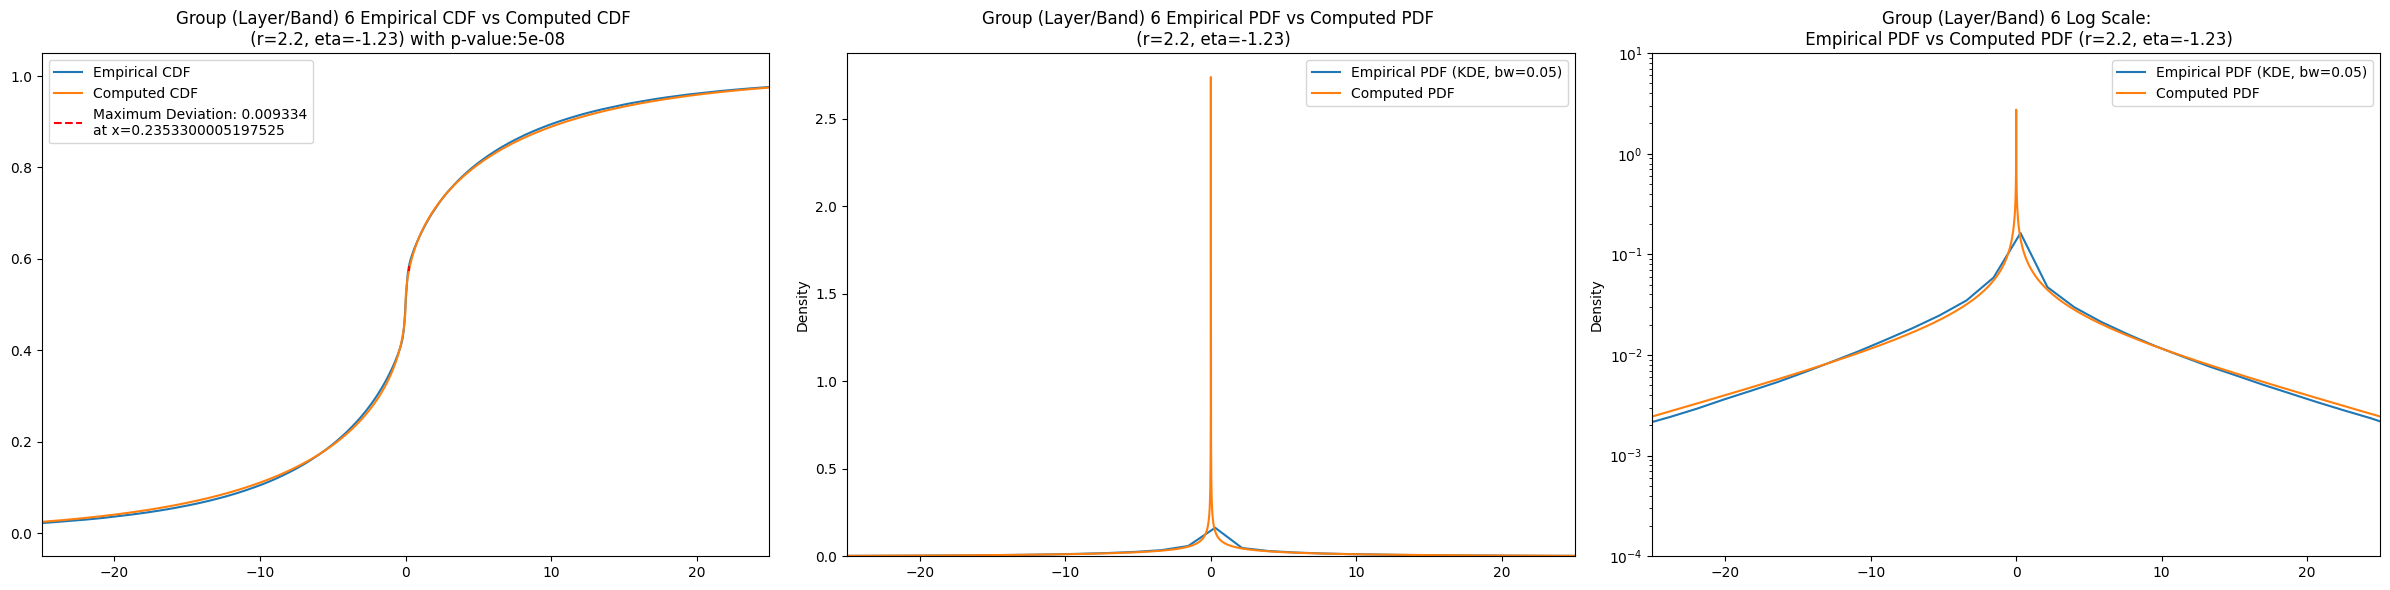

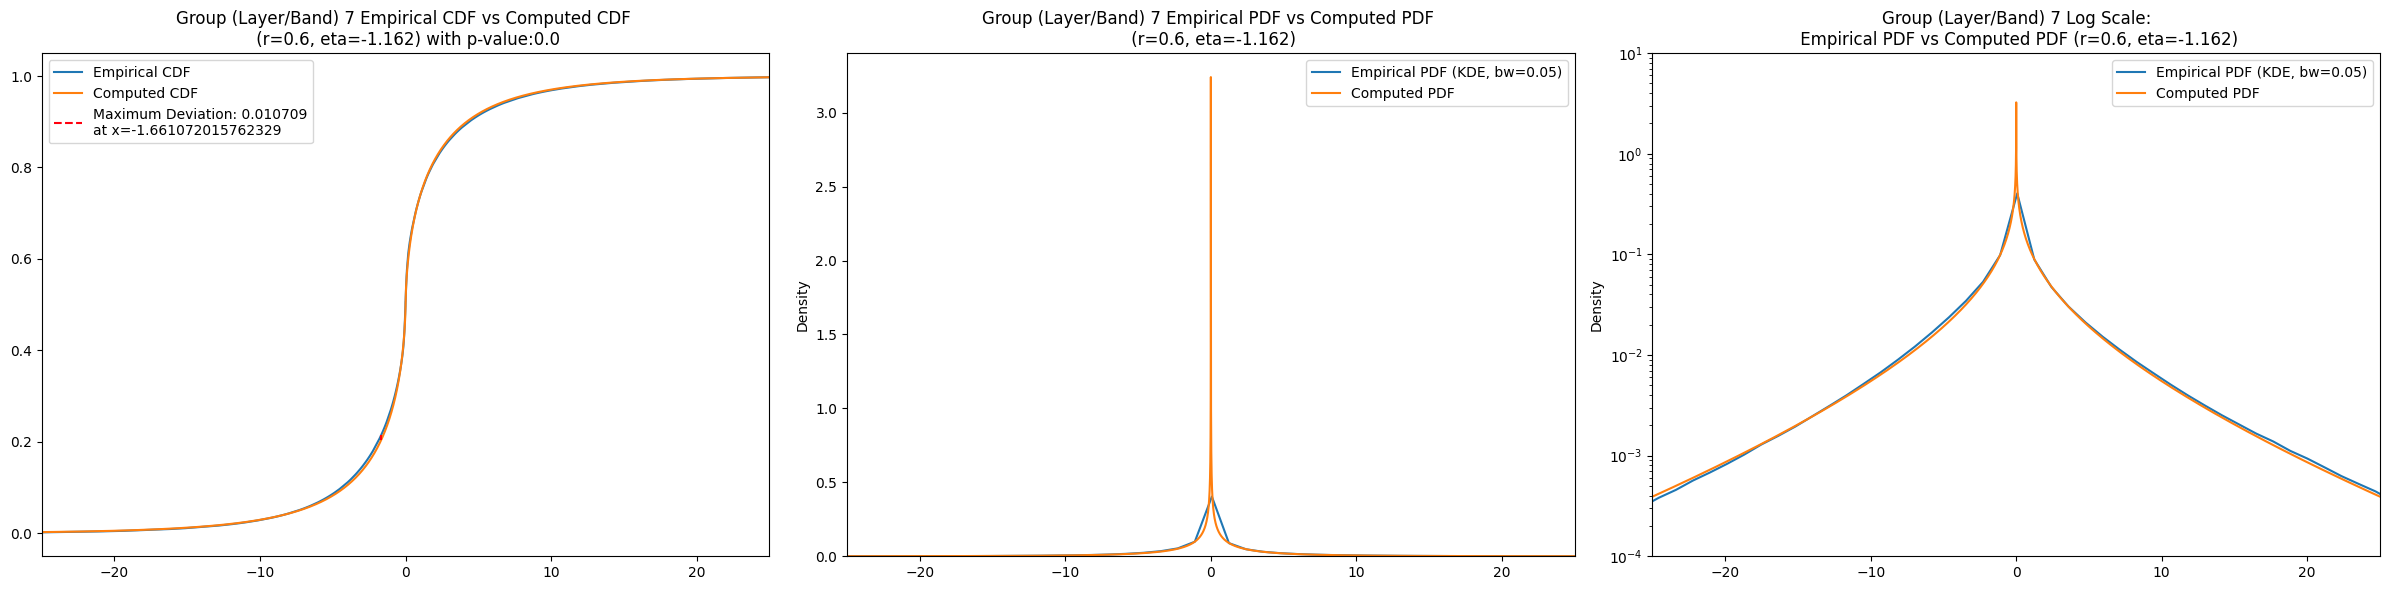

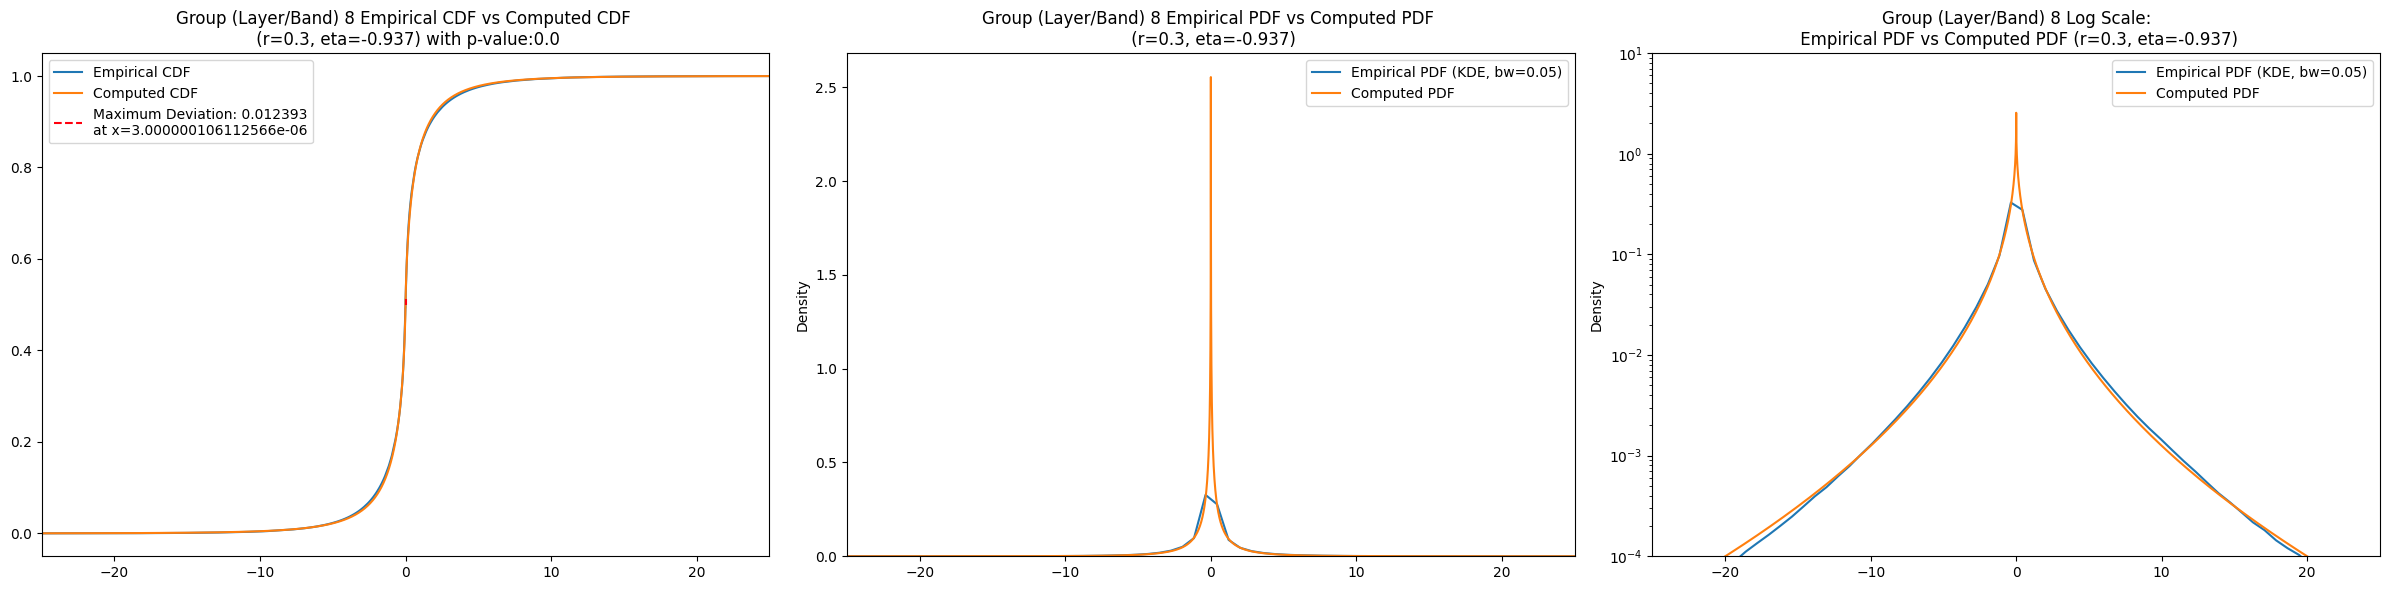

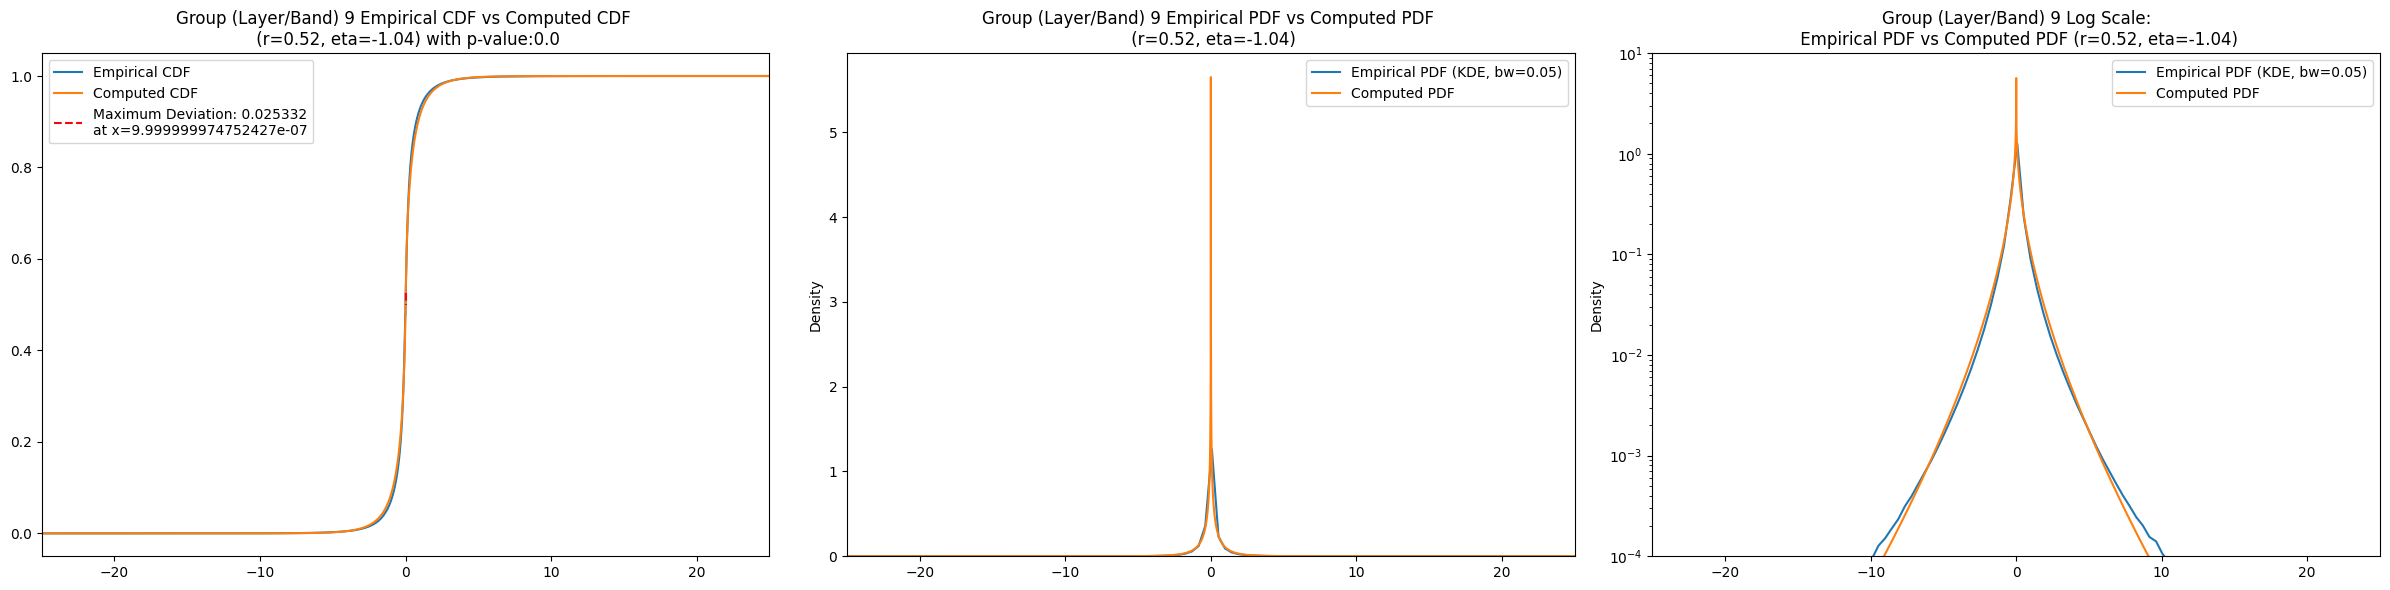

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.877853        27208.0       1.60        -0.97   54039.904937  ...   
3       25.538519       108832.0       0.30        -1.32    1506.594695  ...   
4       18.198275       333298.0       0.69        -1.30    6103.234328  ...   
5       26.454138      1149538.0       2.10        -1.30    3330.115714  ...   
6       22.231544      4251250.0       2.00        -1.23     606.675369  ...   
7       60.509160     17005000.0       0.60        -1.16      37.057163  ...   
8      216.776810     68020000.0       0.30        -0.93       0.156030  ...   
9      464.557600    272080000.0       0.50        -1.03       0.560322  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2          102.032000              0.043843          6.952370e-46   
3           22.542500              0.133839          0.000000e+00   
4           16.978200              0.103783          0.000000e+00   
5            9.975750              0.089730          0.000000e+00   
6            5.256450              0.077096          0.000000e+00   
7            2.104050              0.082592          0.000000e+00   
8            0.881625              0.079140          0.000000e+00   
9            0.445628              0.060203          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          84.795100             0.025508         8.221370e-16  71.377200   
3          15.517800             0.133090         0.000000e+00  12.501500   
4          13.106600             0.091381         0.000000e+00  10.581900   
5           7.723570             0.076333         0.000000e+00   6.212510   
6           4.226530             0.058957         0.000000e+00   3.410630   
7           1.739330             0.060916         0.000000e+00   1.379530   
8           0.763693             0.052915         0.000000e+00   0.599471   
9           0.392223             0.033041         0.000000e+00   0.312648   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.030389   2.902260e-22              0.000057  
3           0.133090   0.000000e+00              0.000000  
4           0.094232   0.000000e+00              0.000000  
5           0.079245   0.000000e+00              0.000000  
6           0.062675   0.000000e+00              0.000000  
7           0.064300   0.000000e+00              0.000000  
8           0.053934   0.000000e+00              0.000000  
9           0.031430   0.000000e+00              0.000000  

[8 rows x 33 columns]

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                     
2      20586.120000  19258.777000  21997.203000    4.579008    3.067372   
3       5586.042500   5083.030300   6169.862300   12.162527    6.823176   
4       1803.625200   1653.475500   1972.172700    9.509400    6.386293   
5        518.531700    474.718600    568.606450   10.222363    6.526305   
6        123.448410    112.812614    135.501390   10.630472    6.988778   
7         26.474886     23.729076     30.007523   18.564669    9.779378   
8          5.566022      4.824710      6.910763   45.434100   13.918406   
9          1.021803      0.856540      1.428081  105.147964   15.814442   

       kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
layer                                                                    ...   
2        6.877853        27208.0       1.60        -0.97   54039.904937  ...   
3       25.538519       108832.0       0.30        -1.32    1506.594695  ...   
4       18.198275       333298.0       0.69        -1.30    6103.234328  ...   
5       26.454138      1149538.0       2.10        -1.30    3330.115714  ...   
6       22.231544      4251250.0       2.00        -1.23     606.675369  ...   
7       60.509160     17005000.0       0.60        -1.16      37.057163  ...   
8      216.776810     68020000.0       0.30        -0.93       0.156030  ...   
9      464.557600    272080000.0       0.50        -1.03       0.560322  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2          102.032000              0.043843          6.952370e-46   
3           22.542500              0.133839          0.000000e+00   
4           16.978200              0.103783          0.000000e+00   
5            9.975750              0.089730          0.000000e+00   
6            5.256450              0.077096          0.000000e+00   
7            2.104050              0.082592          0.000000e+00   
8            0.881625              0.079140          0.000000e+00   
9            0.445628              0.060203          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          84.795100             0.025508         8.221370e-16  71.377200   
3          15.517800             0.133090         0.000000e+00  12.501500   
4          13.106600             0.091381         0.000000e+00  10.581900   
5           7.723570             0.076333         0.000000e+00   6.212510   
6           4.226530             0.058957         0.000000e+00   3.410630   
7           1.739330             0.060916         0.000000e+00   1.379530   
8           0.763693             0.052915         0.000000e+00   0.599471   
9           0.392223             0.033041         0.000000e+00   0.312648   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.030389   2.902260e-22              0.000057  
3           0.133090   0.000000e+00              0.000000  
4           0.094232   0.000000e+00              0.000000  
5           0.079245   0.000000e+00              0.000000  
6           0.062675   0.000000e+00              0.000000  
7           0.064300   0.000000e+00              0.000000  
8           0.053934   0.000000e+00              0.000000  
9           0.031430   0.000000e+00              0.000000  

[8 rows x 33 columns]

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

PermissionError: [WinError 5] Access is denied: 'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\wavelet\\approx1e5\\green\\groupCDFs\\layer2'